In [4]:
from cot_probing.activations import Activations
from cot_probing.eval import EvalResults, EvalQuestion
from cot_probing.typing import *
from fancy_einsum import einsum
import matplotlib.pyplot as plt

import pickle
import torch
import random

with open(
    # "../hf_results/eval_google--gemma-2-9b_ruin_names_S0_N300.pkl", "rb"
    "../hf_results/eval_google--gemma-2-9b_snarks_S0_N151.pkl",
    "rb",
) as f:
    eval_results: EvalResults = pickle.load(f)
print(eval_results)
questions = eval_results.questions
questions[0]

EvalResults(model_name=google/gemma-2-9b, task_name=snarks, seed=0, num_samples=151, 121 questions)


EvalQuestion(3292 tokens, locs keys = ['response'], is_correct=True, answer_char=B)

In [3]:
correct_idxs: list[int] = [q_idx for q_idx, q in enumerate(questions) if q.is_correct]
incorrect_idxs: list[int] = [
    q_idx for q_idx, q in enumerate(questions) if not q.is_correct
]
print(f"Correct: {len(correct_idxs)}")
print(f"Incorrect: {len(incorrect_idxs)}")

Correct: 40
Incorrect: 81


In [5]:
from collections import Counter


def get_counters(idxs: list[int]) -> list[Counter]:
    ret = []
    for q_idx in idxs:
        q: EvalQuestion = questions[q_idx]
        locs = q.locs["response"]
        tokens = q.tokens
        response_tokens = [tokens[loc] for loc in locs]
        counter = Counter(response_tokens)
        ret.append(counter)
    return ret


correct_counters = get_counters(correct_idxs)
incorrect_counters = get_counters(incorrect_idxs)

In [6]:
correct_counter = sum(correct_counters, Counter())
incorrect_counter = sum(incorrect_counters, Counter())

print(correct_counter.most_common(10))
print(incorrect_counter.most_common(10))

[(603, 248), (573, 236), (591, 182), (235265, 180), (674, 166), (476, 154), (665, 151), (235305, 142), (235269, 123), (578, 112)]
[(573, 561), (603, 528), (235265, 399), (591, 373), (674, 359), (476, 322), (665, 321), (235269, 311), (235280, 275), (578, 207)]


In [8]:
all_tokens = sorted(set(correct_counter.keys()).union(set(incorrect_counter.keys())))
print(len(all_tokens))

1157


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(eval_results.model_name)

In [43]:
threshold = 0.2
common_tokens_categories = [
    t
    for t in all_tokens
    if (correct_counter[t] > threshold * len(correct_idxs))
    and (incorrect_counter[t] > threshold * len(incorrect_idxs))
]
print(len(common_tokens_categories))

61


In [44]:
for t in common_tokens_categories:
    print(f"`{tokenizer.decode([t])}` ({t})")

`
` (108)
` a` (476)
` the` (573)
` in` (575)
` of` (576)
` to` (577)
` and` (578)
` (` (591)
` is` (603)
` for` (604)
` be` (614)
` it` (665)
` that` (674)
` with` (675)
` as` (685)
` you` (692)
` at` (696)
` are` (708)
` The` (714)
` not` (780)
` we` (783)
`),` (823)
`).` (846)
` they` (984)
` their` (1024)
` would` (1134)
` This` (1417)
` people` (1461)
` such` (1582)
` look` (1612)
` So` (1704)
` best` (1963)
`If` (2495)
` says` (2889)
` above` (3131)
` answer` (3448)
` valid` (4819)
` option` (4984)
` correct` (5112)
` statement` (6218)
` contains` (7744)
` presence` (8566)
` taste` (10122)
` suggests` (15904)
` neutral` (17120)
` speaker` (18412)
` implies` (21721)
`Above` (49599)
` irony` (65971)
` implying` (90455)
` sarcasm` (105004)
` sarcastic` (108135)
` juxtaposition` (200135)
`t` (235251)
`.` (235265)
`,` (235269)
`)` (235275)
`A` (235280)
`:` (235292)
`'` (235303)
`B` (235305)


In [25]:
# common_tokens_questions = [
#     t
#     for t in all_tokens
#     if all(cnt[t] for cnt in correct_counters)
#     and all(cnt[t] for cnt in incorrect_counters)
# ]
# print(len(common_tokens_questions))
# for t in common_tokens_questions:
#     print(f"`{tokenizer.decode([t])}` ({t})")

24


In [45]:
len(correct_idxs), len(incorrect_idxs)

(40, 81)

` the` (573)          5.90  6.93
` is` (603)           6.20  6.52
`.` (235265)          4.50  4.93
` (` (591)            4.55  4.60
` that` (674)         4.15  4.43
` a` (476)            3.85  3.98
` it` (665)           3.77  3.96
`,` (235269)          3.08  3.84
` and` (578)          2.80  2.56
`B` (235305)          3.55  1.17
` at` (696)           2.20  2.40
`A` (235280)          1.00  3.40
`\n` (108)            2.00  2.36
` we` (783)           2.05  2.23
` look` (1612)        2.05  2.16
`),` (823)            2.00  2.15
`If` (2495)           2.00  2.15
` This` (1417)        2.02  2.02
` statement` (6218)   1.82  2.07
` says` (2889)        1.80  2.10
` of` (576)           2.05  1.62
` to` (577)           1.90  1.37
` sarcastic` (108135)  1.52  1.70
`:` (235292)          1.00  1.36
` as` (685)           1.20  1.15
` not` (780)          0.88  1.47
` answer` (3448)      1.00  1.22
` best` (1963)        1.00  1.17
` above` (3131)       1.00  1.14
` So` (1704)          1.00  1.06
`Above` (

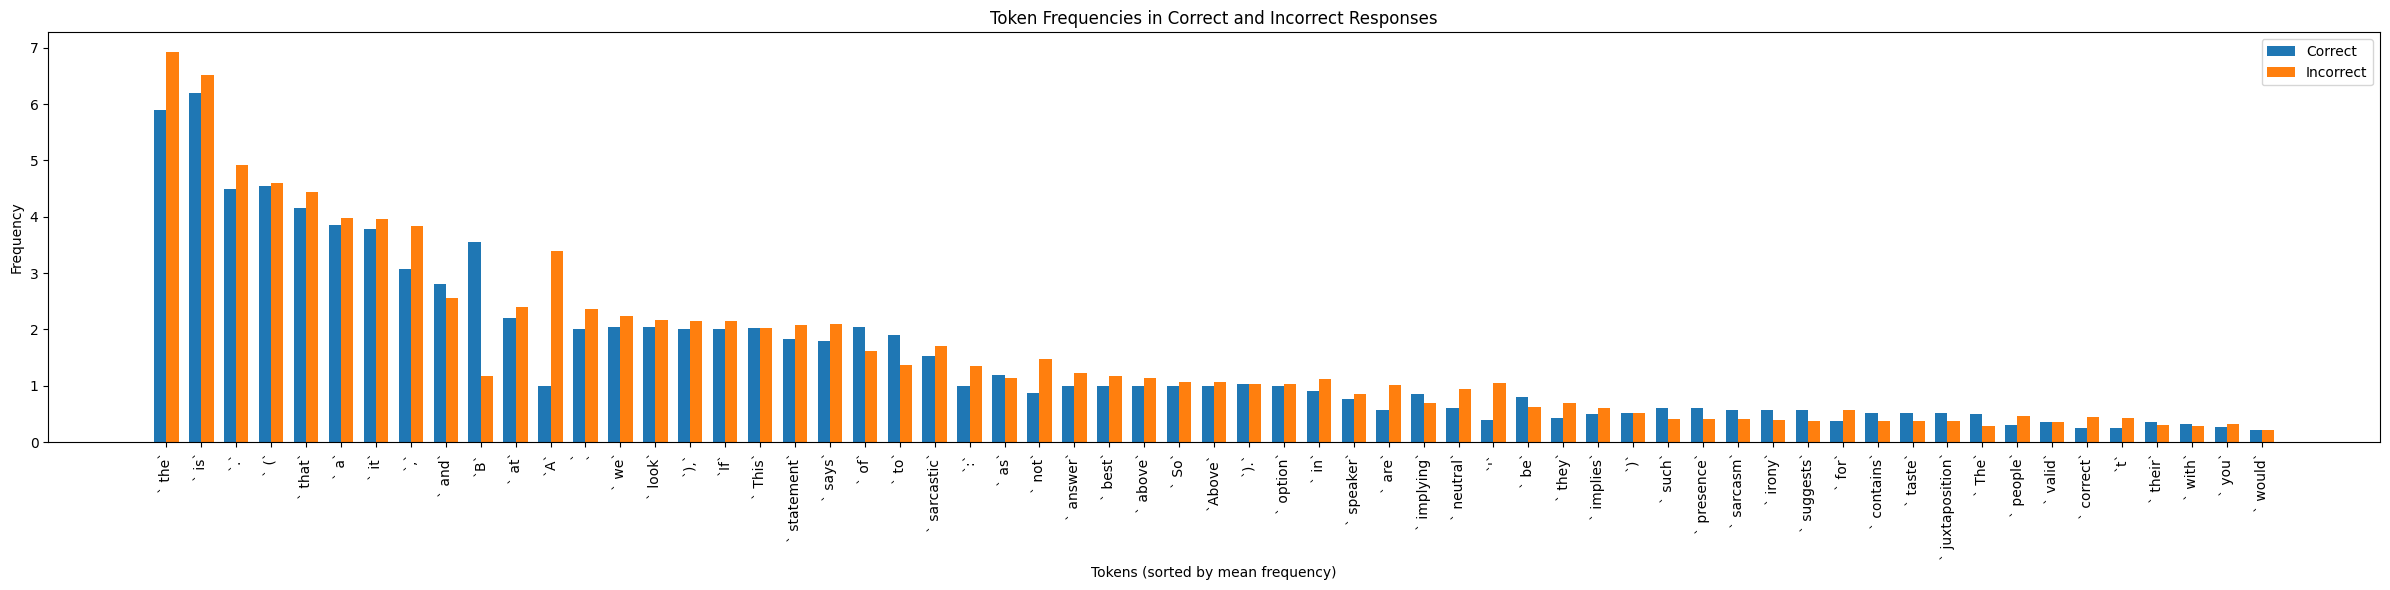

In [46]:
corr_freqs = [correct_counter[t] / len(correct_idxs) for t in common_tokens_categories]
incorr_freqs = [
    incorrect_counter[t] / len(incorrect_idxs) for t in common_tokens_categories
]
mean_freqs = [(corr + incorr) / 2 for corr, incorr in zip(corr_freqs, incorr_freqs)]

# Sort tokens by mean frequency
sorted_indices = sorted(
    range(len(common_tokens_categories)), key=lambda i: mean_freqs[i], reverse=True
)[:100]
sorted_tokens = [common_tokens_categories[i] for i in sorted_indices]
sorted_corr_freqs = [corr_freqs[i] for i in sorted_indices]
sorted_incorr_freqs = [incorr_freqs[i] for i in sorted_indices]
x = list(range(len(sorted_tokens)))

for i in x:
    token = sorted_tokens[i]
    tok_str = tokenizer.decode([token]).replace("\n", r"\n")
    full_tok_str = f"`{tok_str}` ({token})"
    print(
        f"{full_tok_str:20} {sorted_corr_freqs[i]:>5.2f} {sorted_incorr_freqs[i]:>5.2f}"
    )

plt.figure(figsize=(24, 6))
bar_width = 0.35
x_corr = [i - bar_width / 2 for i in x]
x_incorr = [i + bar_width / 2 for i in x]

plt.bar(x_corr, sorted_corr_freqs, width=bar_width, label="Correct")
plt.bar(x_incorr, sorted_incorr_freqs, width=bar_width, label="Incorrect")
plt.legend()
plt.xlabel("Tokens (sorted by mean frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequencies in Correct and Incorrect Responses")
plt.xticks(x, [f"`{tokenizer.decode([t])}`" for t in sorted_tokens], rotation=90)
plt.tight_layout()
plt.show()